<div class="title">Supervised Learning: Case Study</div>
<div class="subtitle">Machine Learning</div>
<div class="author">Carlos María Alaíz Gudín &mdash; Universidad Autónoma de Madrid</div>

---
<div style="font-size: large; font-weight: bold; margin-left: 6em;"><p>Team Number and Names: <u>3: Enrique Juliá Arévalo, Sara Verde Camacho, Leo Pérez Peña</u></div>


**Configuration**

This cell defines the general configuration of Jupyter Notebook.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

This cell imports the packages to be used.

In [100]:
# Standard packages.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys


# Custom packages.
from ml import (
	evaluate_model_clas,
	plot_dataset_clas,
	save_predictions,
	show_function,
)

# Initialisations.
matplotlib.rc("figure", figsize=(15, 5))
sys.dont_write_bytecode = True

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



# Supervised Learning Case Study

## Introduction

This practical assignment is designed as a **Kaggle competition**.

Specifically, a **multiclass classification** dataset will be used, so that each team will compete to improve their predictions over an unlabeled partition of the dataset.

It is important to remark that **the grades will not depend on the obtained ranking**, but on the different approaches used to tackle the problem, on the design of the experiments and on the analysis of the results.

## Rubric

The following aspects will be taken into account when evaluating the assignment.


* Analyse the data.


* Preprocess the features automatically using *pipelines*.


* Adjust the hyper-parameters with a validation stage.


* Try different models to improve the performance, at least:
    * (Regularized) Logistic Regression.
    * SVC.
    * ANNs.


* Try interpretable models to check the important features (e.g. Lasso).


* Submit the prediction several times (the evolution of the performance will be also considered).


* Any other approach that may improve either the performance or interpretability of the model (e.g. feature selection, ensembles...).


* Analyse the results obtained after each experiment, and make decisions following the conclusions.

## Utilities

Some utilities are given next as a starting point, but the teams can define any other tools that they may need.

### Team Number

The **number of the team** should be inserted here, so that the file of predictions has the appropriate name.

In [3]:
################################################################################
# The team number should be inserted here:
team_number = 3
################################################################################

### Evaluation of the Model

The following function evaluates a multiclass model (already fitted), computing and showing the accuracy and balanced accuracy over both the training and test partitions.

In [4]:
show_function(evaluate_model_clas)

```python
def evaluate_model_clas(model, x_tr, y_tr, x_te, y_te, print_table=True):
    y_tr_p = model.predict(x_tr)
    y_te_p = model.predict(x_te)

    er_tr = [accuracy_score(y_tr, y_tr_p), balanced_accuracy_score(y_tr, y_tr_p)]
    er_te = [accuracy_score(y_te, y_te_p), balanced_accuracy_score(y_te, y_te_p)]

    ers = [er_tr, er_te]
    headers = ["Acc", "Bal. Acc"]

    if print_table:
        print("{:>15}".format(""), end="")
        for h in headers:
            print("{:>15}".format(h), end="")
        print("")

        headers_col = ["Train", "Test"]

        cnt = 0
        for er in ers:
            hc = headers_col[cnt]
            cnt = cnt + 1
            print("{:<15}".format(hc), end="")

            for e in er:
                print("{:15.2f}".format(e), end="")
            print("")

    return ers
```

### Submission of the Predictions

The following function saves the predictions on the **challenge partition** to a file with syntax `Team_TT_YYYYMMDD-HHMMSS.pred`, where `TT` stands for the team number, and `YYYYMMDD-HHMMSS` is a timestamp to distinguish the different submissions of a team.

In [5]:
show_function(save_predictions)

```python
def save_predictions(y_ch_p, team_number, n_preds=500):
    if len(y_ch_p) != n_preds:
        print(
            "Error saving the predictions, it should be a vector of %d lables" % n_preds
        )
    else:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.savetxt("Team_{:02d}_{}.txt".format(team_number, time_str), y_ch_p, fmt="%d")
```

Once the prediction file has been generated, it can be uploaded to Moodle.
It is important to **avoid renaming the files**.

## Dataset

A real dataset will be tackled in this practical assignment.
In particular, the [fetal health](https://www.kaggle.com/andrewmvd/fetal-health-classification) dataset of Kaggle, that aims to classify the fetal health in three classes:
1. Normal.
2. Suspect.
3. Pathological.

The input data are a set of $21$ variables extracted from the cardiotocographies (CTGs).

### Load of the Dataset

This cell loads the data, in particular three partitions:
1. A training partition, given by `x_tr` and `y_tr`, to train (and validate) the models.
2. A test partition, given by `x_te` and `y_te`, to estimate the performance of the model.
3. A challenge partition, given by `x_ch`. The real labels are unknown, and hence the predictions should be submitted to know the real performance of the model.

In [6]:
prefix = "./data/fetal_health"

x_tr = np.loadtxt(prefix + "_tr.dat")
x_te = np.loadtxt(prefix + "_te.dat")
x_ch = np.loadtxt(prefix + "_ch.dat")

y_tr = np.loadtxt(prefix + "_tr.lab")
y_te = np.loadtxt(prefix + "_te.lab")

features = [line.rstrip("\n") for line in open("./data/fetal_health.head")]
n_features = len(features)

### Initial Analysis

Plot of the data over the first two features.

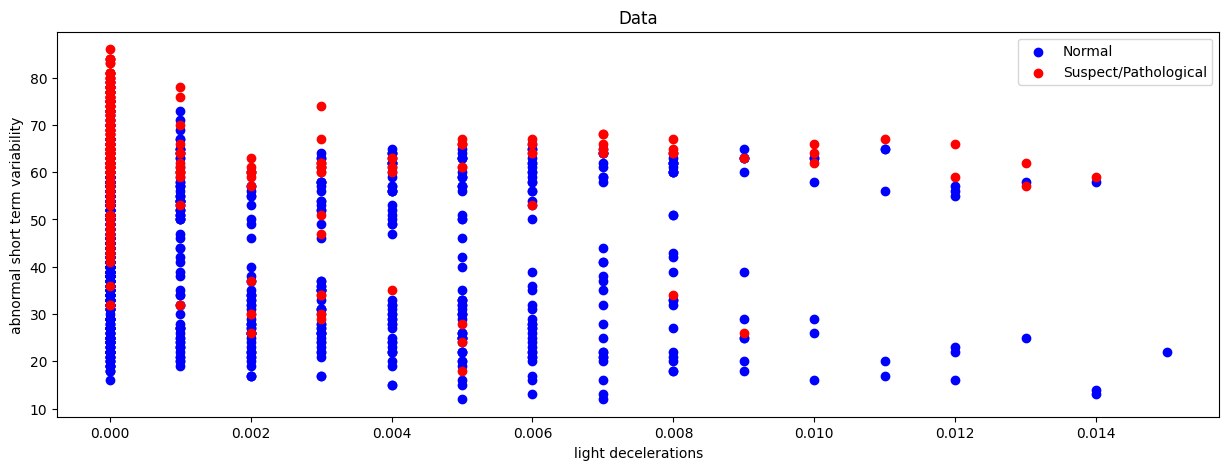

In [7]:
y_tr_binary = y_tr.copy()
y_tr_binary[y_tr == 3] = 2
plot_dataset_clas(x_tr, y_tr_binary)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(["Normal", "Suspect/Pathological"])
plt.axis("auto")
plt.show()

Al representar los datos en base a los dos primeros atributos (light decelerations y abnormal short term variability), podemos ver que no hay una separación clara entre clases, y lo mismo sucede si representamos los datos en base a otros dos atributos cualquiera. 

Si trazásemos una línea horizontal en torno a, por ejemplo, y = 50, y consideráramos que a cada lado de la línea tenemos una clase, nos estaríamos equivocando en muchos casos. Por tanto, puede que un modelo lineal no sea la mejor solución para resolver este problema de clasificación (aunque eso lo comprobaremos más adelante).

Balance of the dataset.

In [8]:
for lab in np.unique(y_tr):
    n_sam = np.sum(y_tr == lab)
    print(
        "Class {}: {:3d} samples ({:5.2f}%)".format(
            lab, n_sam, 100.0 * n_sam / len(y_tr)
        )
    )

Class 1.0: 877 samples (77.89%)
Class 2.0: 156 samples (13.85%)
Class 3.0:  93 samples ( 8.26%)


Con este análisis, lo primero que vemos es que las clases no están balanceadas. Por tanto, fijarnos únicamente en el valor de accuracy no tiene sentido, ya que en este caso se trata de una medida engañosa. Por ejemplo, si la clase mayoritaria constituye casi un 80% de los datos, un modelo que siempre predice la clase mayoritaria tendrá una precisión de casi 0.8, a pesar de no estar aprendiendo nada acerca del conjunto de datos. 

Por eso, debemos prestarle más atención al valor de balanced accuracy, que se calcula dándole la misma importancia a todas las clases.

Esto que acabamos de comentar se pone de manifiesto al utilizar el clasificador DummyClasifier, utilizando la estrategia de predecir la clase más frecuente: 

In [9]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_tr, y_tr)
_ = evaluate_model_clas(dummy_clf, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.78           0.33
Test                      0.78           0.33


Al calcular la balanced accuracy, se ve claramente que, a pesar de tener una precisión 0.78, solo se está prediciendo correctamente una de las clases.

In [10]:
y_ch = dummy_clf.predict(x_ch)
# save_predictions(y_ch, 3)

Necesitamos, por tanto, recurrir a clasificadores más sofisticados:

## Regresión logística

A diferencia de la regresión lineal (que predice un número), la regresión logística predice la probabilidad de que una observación pertenezca a una clase.

Como en la regresión lineal, primero calcula una combinación lineal de las variables de entrada. Para convertir dicha combinación en una probabilidad, se pasa por la función logística o sigmoide. Esta función devuelve un valor entre 0 y 1, interpretado como la probabilidad de que la observación pertenezca a una clase. En un problema de clasificación binaria, si la probabilidad es igual o mayor de 0.5, asignamos la observación a dicha clase, y, si es menor de 0.5, la asignamos a la otra. 

Este método también se puede aplicar problemas de clasificación multiclase, con algunas modificaciones.

En general, la regresión logística funciona bien si las clases son linealmente separables. Además, permite regularización (L1 - Lasso, L2 - Ridge) para evitar sobreajuste.

Puesto que tanto éste como los siguientes clasificadores tienen en cuenta el input para realizar predicciones, es necesario que nuestros datos estén normalizados. Por tanto, antes de realizar el ajuste del modelo, añadiremos siempre un paso de preprocesamiento con StandardScaler de Scikit-learn, en el que transformamos los datos para que éstos tengan una media de 0 y una desviación estándar de 1. 

In [11]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)


                           Acc       Bal. Acc
Train                     0.91           0.82
Test                      0.90           0.79


La precisión de la predicción mejora considerablemente en comparación con DummyClassifier. No obstante, como ya anticipábamos al hacer un análisis rápido de los datos, al establecer una frontera de decisión lineal cometemos algunos errores de predicción (hay observaciones que son clasificadas erróneamente). 

In [12]:
y_ch = pipeline.predict(x_ch)
# save_predictions(y_ch, 3)

Como comentábamos antes, con la regresión logística estamos asumiendo que entre las distintas variables existe una relación lineal. Sin embargo, es posible que no sea así. 

Con PolynomialFeatures (también de scikit-learn), podemos transformar las variables originales en una expansión polinómica de ellas, lo que nos permite capturar relaciones no lineales.

A continuación, repetiremos el proceso anterior añadiendo un paso de preprocesado con PolynomialFeatures, utilizando GridSearchCV para determinar el grado del polinomio más adecuado para capturar relaciones complejas entre las variables, a ver si así conseguimos mejorar la capacidad predictiva del modelo.

In [52]:
from sklearn.preprocessing import PolynomialFeatures

pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'poly__degree': [1, 2, 3, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)

grid.fit(x_tr, y_tr)

print("Mejor grado de polinomio:", grid.best_params_['poly__degree'])

_ = evaluate_model_clas(grid.best_estimator_, x_tr, y_tr, x_te, y_te)


Mejor grado de polinomio: 2
                           Acc       Bal. Acc
Train                     0.97           0.94
Test                      0.89           0.76


Aquí vemos cómo al introducir interacciones y términos cuadráticos (polinomio de grado 2), conseguimos ajustarnos mejor a los datos de entrenamiento. Sin embargo, la balanced accuracy para el conjunto de prueba es significativamente menor (de hecho, es menor que cuando asumíamos una relación lineal entre variables). Esto se debe a que, al utilizar un modelo más complejo, se está produciendo sobreajuste, y, por tanto, estamos perdiendo capacidad de generalización.

Descartamos esta estrategia, y procedemos a ajustar modelos de regresión logística aplicando distintos tipos de regularización.

Con la regularización, lo que hacemos es penalizar la complejidad, de forma que nos permite obtener modelos robustos con menor riesgo de sobreajuste.

Existen varios tipos de regularización, entre los que destacan l2 y l1:

- Con l2, los coeficientes del modelo se llevan tan cerca de 0 como sea posible, sin que ninguno de ellos llegue a valer exactamente 0. 

- Con l1, los coeficientes del modelo se llevan tan cerca de 0 como sea posible y, además, sí que pueden valer 0. Con l1, por lo tanto, podemos ignorar características redundantes o irrelevantes, obteniendo modelos aún más sencillos. 

A continuación probaremos la regresión Ridge, que se basa en l2; la regresión Lasso, que se basa en l1; y Elastic Net, que es una combinación de los anteriores.

## Regresión Ridge

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="l2"))
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.91           0.82
Test                      0.90           0.79


In [15]:
y_ch = pipeline.predict(x_ch)
# save_predictions(y_ch, 3)

Al utilizar el modelo de regresión Ridge, obtenemos el mismo resultado que al utilizar el modelo de regresión lineal. Esto se debe a que antes, por defecto, ya estábamos aplicando la regularización l2.

## Regresión Lasso

In [16]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="l1", solver="saga", max_iter=2000))
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.92           0.82
Test                      0.90           0.80


Con la regresión Lasso, la balanced accuracy en el conjunto de prueba aumenta ligeramente con respecto a la regresión Ridge, aunque no mucho. Esto significa que el poder deshacernos de características redundantes o irrelevantes no supone ninguna ventaja en este caso: todos los atributos parecen ser importantes.

Podemos ver qué características se están teniendo en cuenta con el siguiente bloque de código:

In [17]:
clf = pipeline.named_steps['clf']

# Obtenemos la matriz con los coeficientes (n_clases, n_atributos)
coef = clf.coef_

# Seleccionamos aquellos atributos con coeficientes distintos de 0 en alguna clase
selected_indices = np.where(np.any(coef != 0, axis=0))[0]

print("Índices de características seleccionadas (coef ≠ 0 en alguna clase):")
print(selected_indices)



Índices de características seleccionadas (coef ≠ 0 en alguna clase):
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17 18 19 20]


Como suponíamos, todas las características son importantes para realizar la clasificación.

In [18]:
y_ch = pipeline.predict(x_ch)
# save_predictions(y_ch, 3)

## Elastic Net

El siguiente paso es probar Elastic Net, utilizando GridSearchCV para encontrar el mejor valor de l1_ratio (l1_ratio = 0 significa que solo estamos usando Ridge, mientras que l1_ratio = 1 significa que solo estamos usando Lasso):

In [53]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="elasticnet", solver="saga", max_iter=2000))
])

param_grid = {
    'clf__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy')
grid.fit(x_tr, y_tr)

_ = evaluate_model_clas(grid.best_estimator_, x_tr, y_tr, x_te, y_te)

print("Mejor l1_ratio encontrado:", grid.best_params_['clf__l1_ratio'])


                           Acc       Bal. Acc
Train                     0.92           0.82
Test                      0.90           0.79
Mejor l1_ratio encontrado: 0.5


La combinación de ambos tipos de regularización tampoco parece ofrecer ninguna ventaja.

## Selección de atributos con SelectKBest

Otra forma de seleccionar los atributos relevantes sin tener que recurrir a Lasso es SelectKBest. A continuación, volveremos a probar los 4 modelos anteriores realizando la selección de esta otra forma.

Empezamos con la regresión logística, eligiendo un número aleatorio de atributos (10) para ver si se produce alguna mejora:

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(k=10)),
    ('clf', LogisticRegression())
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.89           0.78
Test                      0.88           0.73


In [21]:
y_ch = pipeline.predict(x_ch)
# save_predictions(y_ch, 3)

10 no parece ser un número de atributos adecuado, por lo que recurrimos nuevamente a GridSearchCV:

In [55]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif)),
    ('clf', LogisticRegression())
])

param_grid = {'select__k':np.linspace(1, n_features,2).astype(int),}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy')
grid.fit(x_tr, y_tr)

best_k = grid.best_params_['select__k']
print("Mejor número de atributos: ", int(best_k))

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)

Mejor número de atributos:  21
                           Acc       Bal. Acc
Train                     0.91           0.82
Test                      0.90           0.79


In [ ]:
y_ch = pipeline.predict(x_ch)
# save_predictions(y_ch, 3)

Nuevamente, el mejor número de características posible es el máximo. Lo mismo sucede si en lugar de regresión logística empleamos regresión Ridge:

In [56]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif)),
    ('clf', LogisticRegression(penalty="l2"))
])

param_grid = {'select__k':np.linspace(1, n_features,2).astype(int),}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy')
grid.fit(x_tr, y_tr)

best_k = grid.best_params_['select__k']
print("Mejor número de atributos: ", int(best_k))

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)

Mejor número de atributos:  21
                           Acc       Bal. Acc
Train                     0.91           0.82
Test                      0.90           0.79


In [24]:
y_ch = grid.predict(x_ch)
# save_predictions(y_ch, 3)

Puesto que no conseguimos mejorar la balanced accuracy de ninguna forma, procedemos a utilizar otros clasificadores.

## Support Vector Classifier

El objetivo de este clasificador es encontrar el hiperplano que mejor separa las clases en el espacio de características, maximizando el margen entre las observaciones de distintas clases.

Cuando los datos originales no son linealmente separables, este clasificador usa el truco del kernel para llevarlos a un espacio de mayor dimensión donde sí lo son. Los kernels más utilizados son: 'linear' (no hay transformación), 'polynomial', 'rbf' (gaussiano) y 'sigmoid'.

El parámetro C nos permite definir la tolerancia del modelo al error, que son los puntos mal clasificados o dentro del margen. Cuanto más elevado es el valor de C, menor es la tolerancia al error, lo que puede resultar en sobreajuste. Por el contrario, cuanto más bajo es el valor de C, más permisivo será nuestro modelo y, por lo tanto, más general.

A parte del kernel y el valor de C, SVC cuenta con otros hiperparámetros que debemos optimizar para obtener el mejor resultado posible:

- Degree (si el kernel es 'poly'): grado del polinomio.

- Gamma (si el kernel es 'poly', 'rbf' o 'sigmoid'): cuánta influencia tiene un solo punto de entrenamiento en la forma de la frontera de decisión. Si el valor de gamma es bajo, obtendremos una frontera de decisión más suave, lo que resulta en un modelo más general. Si el valor de gamma es alto, obtendremos una frontera de decisión más compleja, lo que resulta en un mayor riesgo de sobreajuste.

La optimización de todos estos hiperparámetros la realizaremos utilizando GridSearchCV, como en los casos anteriores.

In [84]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

param_grid = {
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.1, 1, 10],
    'clf__degree': [2, 3, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid.fit(x_tr, y_tr)

print("Mejores parámetros: ", grid.best_params_)

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)

Mejores parámetros:  {'clf__C': 100, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
                           Acc       Bal. Acc
Train                     0.99           0.98
Test                      0.92           0.84


In [ ]:
y_ch = grid.predict(x_ch)
# save_predictions(y_ch, 3)

Puesto que nuestras clases están desbalanceadas, probamos a repetir el proceso con class_weight='balanced', que penaliza más los errores en las clases minoritarias para evitar un sesgo hacia la clase mayoritaria.

In [85]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(class_weight='balanced'))
])

param_grid = {
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.1, 1, 10],
    'clf__degree': [2, 3, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid.fit(x_tr, y_tr)

print("Mejores parámetros: ", grid.best_params_)

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)


Mejores parámetros:  {'clf__C': 1, 'clf__degree': 3, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
                           Acc       Bal. Acc
Train                     0.95           0.97
Test                      0.91           0.87


Al introducir esta pequeña modificación, la balanced accuracy en el conjunto de prueba aumenta. Además, parece que los hiperparámetros que mejor funcionan son el kernel 'poly', C = 1, degree = 3 (polinomio de grado 3) y gamma = 0.1.

In [ ]:
y_ch = grid.predict(x_ch)
# save_predictions(y_ch, 3)

Para asegurarnos de que la selección de hiperparámetros no se está viendo afectada por el ruido y que es estable y confiable, repetiremos el proceso una vez más. En este caso, lo que haremos serán múltiples evaluaciones con RepeatedStratifiedKFold:

In [88]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(class_weight='balanced'))
])

param_grid = {
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.1, 1, 10],
    'clf__degree': [2, 3, 4]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid.fit(x_tr, y_tr)

print("Mejores parámetros: ", grid.best_params_)

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)

Mejores parámetros:  {'clf__C': 10, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
                           Acc       Bal. Acc
Train                     0.95           0.97
Test                      0.90           0.89


Al hacer esto, nos sale que el kernel que mejor funciona es 'rbf' (igual que al principio), con los hiperparámetros C = 10 y gamma = 'scale'. Obtenemos un valor de balanced accuracy en el conjunto de prueba de 0.89, que es el más alto hasta ahora, por lo que utilizar RepeatedStratifiedKFold ha sido una buena idea. 

Ahora procederemos a probar los modelos estudiados en partes anteriores de la asignatura, a ver si podemos mejorar el valor de balanced accuracy obtenido.

In [ ]:
y_ch = pipeline.predict(x_ch)
# save_predictions(y_ch, 3)

## Naive Bayes

Este clasificador calcula la probabilidad de cada clase usando la regla de Bayes, y luego asigna la clase con mayor probabilidad.

El problema de este clasificador es que asume independencia entre las diferentes características, por lo que no funciona muy bien cuando los atributos están relacionados entre sí. 

In [66]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GaussianNB())
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.79           0.50
Test                      0.79           0.49


La balanced accuracy de este modelo es muy baja, lo que nos hace pensar que las características están relacionadas.

In [27]:
y_ch = grid.predict(x_ch)
# save_predictions(y_ch, 3)

Ahora probaremos clasificadores que no asumen independencia entre características: 

## Árboles de decisión

Este clasificador va separando los datos en función de sus valores para las diferentes caracterísiticas, al igual que el tronco de un árbol de divide en ramas. Después, asigna a cada observación una clase en función del camino que siguió en el árbol.

El proceso es el siguiente: 

1) El algoritmo busca la característica y el punto de corte que mejor separan los datos. Para determinar cómo de bien se separan los datos, emplea criterios como 'gini' o 'entropy'. 

2) El conjunto de datos se divide en dos (o más) grupos según esa característica.

3) El proceso se repite de manera recursiva hasta que se cumpla una condición de parada, como puede ser que todas las muestras del grupo pertenezcan a la misma clase, que el número de muestras por nodo sea demasiado bajo o que hayamos alcanzado la profundidad máxima del árbol.

Además del criterio para medir la calidad de división y la condición de parada, este clasificador cuenta con una gran variedad de hiperparámetros, que optimizaremos, como siempre, usando GridSearchCV.

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=0))
])

param_grid = {'clf__criterion': ['gini', 'entropy', 'log_loss'],
              'clf__max_depth': [None, 5, 10, 20, 30],
              'clf__max_features': [None, 'sqrt', 'log2'], # Número máximo de características consideradas por división
              'clf__max_leaf_nodes': [None, 10, 20, 50, 100] # Número máximo de de hojas en el árbol
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy')
grid.fit(x_tr, y_tr)

print("Mejores parámetros: ", grid.best_params_)

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)

Mejores parámetros:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': None, 'clf__max_leaf_nodes': 10}
                           Acc       Bal. Acc
Train                     0.85           0.91
Test                      0.86           0.90


Obtenemos un valor de balanced accuracy igual de bueno que con SVC, a pesar de que este clasificador funciona de forma completamente distinta. Al igual que en el caso anterior, para asegurarnos de que la selección de hiperparámetros es estable y confiable, repetimos el proceso utilizando RepeatedStratifiedKFold.

In [99]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=0))
])

param_grid = {'clf__criterion': ['gini', 'entropy', 'log_loss'],
              'clf__max_depth': [None, 5, 10, 20, 30],
              'clf__max_features': [None, 'sqrt', 'log2'],
              'clf__max_leaf_nodes': [None, 10, 20, 50, 100]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy')
grid.fit(x_tr, y_tr)

print("Mejores parámetros: ", grid.best_params_)

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)

Mejores parámetros:  {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': None, 'clf__max_leaf_nodes': 20}
                           Acc       Bal. Acc
Train                     0.90           0.95
Test                      0.86           0.89


Al hacer múltiples evaluaciones, vemos que en realidad el mejor criterio no es 'gini', sino 'entropy', y el número máximo de hojas en el árbol es 20. Es un árbol complejo, pero no demasiado. El valor de balanced accuracy es mayor para el conjunto de entrenamiento que para el de prueba, pero la diferencia no es suficientemente grande como para pensar que se está produciendo sobreajuste.

Este clasificador funciona tan bien como SVC.

In [29]:
y_ch = grid.predict(x_ch)
# save_predictions(y_ch, 3)

Dado el buen rendimiento de los árboles de decisión, lo siguiente que haremos será probar Random Forest, que es un modelo ensamblado en el que se generan muchos árboles y después se combinan sus predicciones. Con esto reducimos el riesgo de sobreajuste y, en teoría, mejoramos la capacidad de generalización.

## Random Forest

In [115]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=0))
])

param_grid = [
    {
        'clf__criterion': ['gini', 'entropy', 'log_loss'],
        'clf__max_depth': [10, 20, 30],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__max_leaf_nodes': [10, 20, 50],
        'clf__n_estimators': [100, 500, 1000],
        'clf__bootstrap': [True],
        'clf__max_samples': [0.5, 0.7, 0.9],

    },
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid.fit(x_tr, y_tr)

print("Mejores parámetros: ", grid.best_params_)

_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)


Mejores parámetros:  {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__max_leaf_nodes': 20, 'clf__max_samples': 0.9, 'clf__n_estimators': 500}
                           Acc       Bal. Acc
Train                     0.93           0.96
Test                      0.89           0.86


En este caso, la construcción de diversos árboles (500) no ha mejorado nuestra capacidad de generalización, por lo que, puestos a elegir, por tiempo de ejecución e interpretabilidad, nos quedaríamos con el árbol de decisión frente a Random Forest. 

Convendría realizar una búsqueda de hiperparámetros más exhaustiva para aprovechar al máximo el potencial del ensamblaje, sin embargo, nuestros ordenadores no tienen la capacidad necesaria para hacer eso.

Por ello, probaremos con otro clasificador diferente.

## K Nearest Neighbors

Este clasificador funciona de la siguiente forma:

1) Para cada punto, calcula la distancia al resto de puntos.

2) Ordena los puntos según la distancia y selecciona los k vecinos más cercanos.

3) Asigna la clase mayoritaria entre esos vecinos.

Los hiperparámetros que podemos ajustar en este caso son los siguientes:

- n_neighbors: Número de vecinos que se consideran. Cuanto más alto, más general será nuestro modelo.

- weights: Importancia que tiene cada vecino en la toma de decisiones. Usamos 'uniform' cuando queremos que todos los vecinos tengan el mismo peso, mientras que con 'distance' los vecinos más cercanos tienen más peso.

- p: Cómo se miden las distancias. p=1 significa Manhattan, y p=2 Euclidiana.

La optimización de estos hiperparámetros se llevará a cabo, otra vez, con GridSearchCV.

In [118]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': np.arange(1, 21), # K
    'knn__weights': ['uniform', 'distance'], # Peso de los vecinos
    'knn__p': [1, 2] # Distancia: p=1 Manhattan, p=2 Euclidiana
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(x_tr, y_tr)

print("Mejores parámetros:", grid.best_params_)
_ = evaluate_model_clas(grid, x_tr, y_tr, x_te, y_te)


Mejores parámetros: {'knn__n_neighbors': np.int64(3), 'knn__p': 1, 'knn__weights': 'distance'}
                           Acc       Bal. Acc
Train                     1.00           1.00
Test                      0.91           0.78


In [33]:
y_ch = grid.predict(x_ch)
# save_predictions(y_ch, 3)

Este clasificador tampoco funciona mejor que los anteriores.

## CONCLUSIÓN

De todos los clasificadores que hemos probado, los que mejor nos han funcionado son SVC y el árbol de decisión, que nos dan valores de balanced accuracy en torno a 0.9. 

Sin embargo, si tuviéramos que elegir uno de los dos, probablemente sería el árbol de decisión, ya que es mucho más interpretable (puedes ver fácilmente cómo se toman las decisiones). SVC es más una “caja negra” (sobre todo con kernels no lineales), es decir, menos intuitivo. Dado que estamos tratando de diagnosticar una enfermedad, la interpretabilidad del clasificador es crucial, de cara a poder darle una explicación coherente a un paciente.

En términos de robustez, el árbol de decisión tiende a sobreajustar más, aunque esto se puede controlar con los distintos hiperparámetros (o con Random Forest, si encuentras la combinación de hiperparámetros adecuada).

Por último, los árboles de decisión son más rápidos, lo que los hace mucho más prácticos. SVC puede ser costoso computacionalmente, especialmente con kernels no lineales y grandes conjuntos de datos.

Por todo esto, creemos que la mejor de las opciones en este caso es el árbol de decisión.